<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/rl_util/use_rl_util.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and imports

In [0]:
%tensorflow_version 1.x

!pip uninstall lucid -y
!pip install git+https://github.com/tensorflow/lucid.git#egg=lucid

!git clone https://github.com/arunraja-hub/Preference_Extraction.git

!pip install tf-agents==0.3.0

!pip uninstall tensorflow-probability -y
!pip install tensorflow-probability==0.7.0

!npm install -g svelte-cli@2.2.0

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

TensorFlow 1.x selected.
Uninstalling lucid-0.3.9:
  Successfully uninstalled lucid-0.3.9
  Cloning https://github.com/tensorflow/lucid.git to /tmp/pip-install-vadg0fo5/lucid
  Running command git clone -q https://github.com/tensorflow/lucid.git /tmp/pip-install-vadg0fo5/lucid
  Created wheel for lucid: filename=lucid-0.3.9-cp36-none-any.whl size=155742 sha256=6ccd37c1df89664972067c47d42ba003be2642f1a287e91214ea0acabd864765
  Stored in directory: /tmp/pip-ephem-wheel-cache-pteuwhmr/wheels/64/c2/51/7238e75f457453774587708b21cd3cf32f9a86456648688634
Successfully built lucid
fatal: destination path 'Preference_Extraction' already exists and is not an empty directory.
Uninstalling tensorflow-probability-0.7.0:
  Successfully uninstalled tensorflow-probability-0.7.0
  Using cached https://files.pythonhosted.org/packages/3e/3a/c10b6c22320531c774402ac7186d1b673374e2a9d12502cbc8d811e4601c/tensorflow_probability-0.7.0-py2.py3-none-any.whl
/tools/node/bin/svelte -> /tools/node/lib/node_modules/s

In [0]:
import numpy as np

from tf_agents.trajectories.time_step import TimeStep
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import BoundedTensorSpec
from tf_agents.networks import q_network

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map


import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import numpy as np
import io
import collections

import urllib.request
from urllib.error import HTTPError

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read data

In [0]:
class Trajectory(
    collections.namedtuple('Trajectory', [
        'step_type',
        'observation',
        'action',
        'policy_info',
        'next_step_type',
        'reward',
        'discount',
    ])):
  """Stores the observation the agent saw and the action it took.
      The rest of the attributes aren't used in this code."""
  __slots__ = ()

class ListWrapper(object):
  def __init__(self, list_to_wrap):
    self._list = list_to_wrap

  def as_list(self):
    return self._list

class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
      if name == "Trajectory":
        return Trajectory
      if name == "ListWrapper":
        return ListWrapper

      return super(RenameUnpickler, self).find_class(module, name)

def rename_load(s):
    """Helper function analogous to pickle.loads()."""
    return RenameUnpickler(s, encoding='latin1').load()

In [0]:
# Modified read trajectories functions to read files from local storage

def load_file(full_path):
    try:
        with open(full_path, 'rb') as f:
            data = rename_load(f)
            return data
    except:
        return None
    
def all_load_data(base_path):
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    
    futures = []
    for i in range(5000):
        full_path = os.path.join(base_path, "ts"+str(i)+".pickle")
        future = executor.submit(load_file, full_path)
        futures.append(future)
    
    raw_data = []
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            raw_data.append(result)
    
    return raw_data


all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")

In [0]:
all_observations = []

for data in all_raw_data:
  for i in range(data.observation.shape[0]):
    obs = np.copy(data.observation[i])

    all_observations.append(np.array(obs))

all_observations = np.array(all_observations)

In [0]:
all_observations.shape

(23750, 14, 16, 5)

# Load model and run lucid grouping code

In [0]:
model = models.Model.load("Preference_Extraction/lucid_save_model.pb")
model.load_graphdef()

In [0]:
from lucid.scratch.rl_util import *

In [0]:
some_observations = all_observations[0:200]

In [0]:
output_layer_name = "QNetwork/dense/BiasAdd"
# hidden_layer_name = "QNetwork/EncodingNetwork/EncodingNetwork/conv2d_1/Relu"
hidden_layer_name = "QNetwork/EncodingNetwork/EncodingNetwork/conv2d/Relu"

In [0]:
nmf = LayerNMF(model, hidden_layer_name, some_observations, features=8, attr_layer_name=output_layer_name)

In [0]:
score_fn = lambda x: tf.reduce_max(x) - tf.reduce_sum(x)
# score_fn = lambda x: x[1] - tf.reduce_sum(x)
attr = get_attr(model, output_layer_name, hidden_layer_name, some_observations, integrate_steps=10, score_fn=score_fn, )

In [0]:
print(np.min(attr))
print(np.max(attr))
print(attr.shape)

-245.50542
162.56981
(200, 12, 14, 16)


In [0]:
# attr_reduced = nmf.transform(np.maximum(attr, 0)) - nmf.transform(np.maximum(-attr, 0))
attr_reduced = nmf.transform(np.abs(attr))
normalize_by = np.median(attr_reduced.max(axis=(-3, -2, -1)))
print(normalize_by)
attr_reduced /= normalize_by # normalize to make the visualization balanced, may need tweaking
attr_reduced = np.abs(attr_reduced)
attr_reduced = conv2d(attr_reduced, filter_=norm_filter(15)) # smooth out attribution over nearby spatial positions, to make it easier to judge attribution strength of sparse attribution

2.190571867011738


In [0]:
print(attr_reduced.shape)

(200, 12, 14, 8)



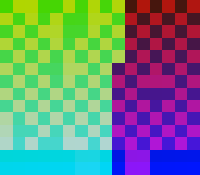
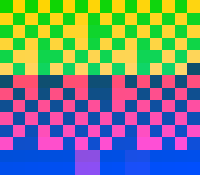
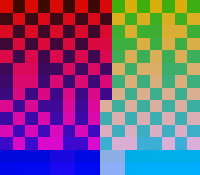
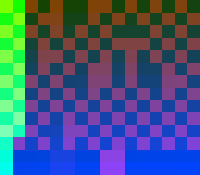
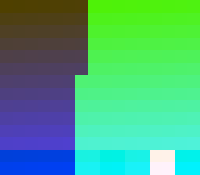
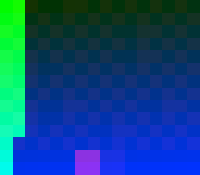
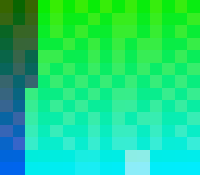
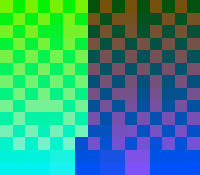
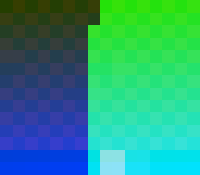
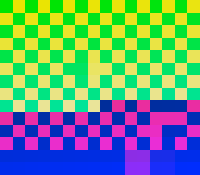


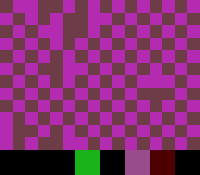
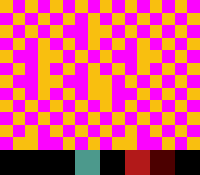
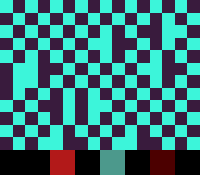
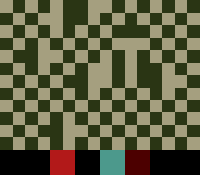
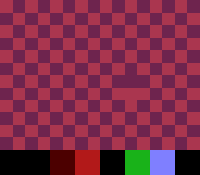
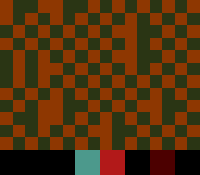
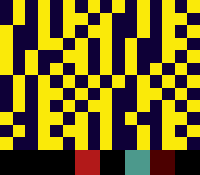
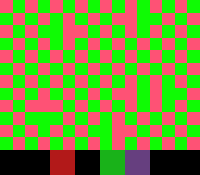
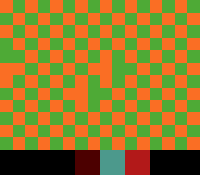
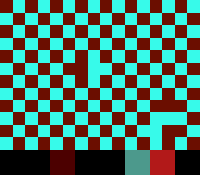


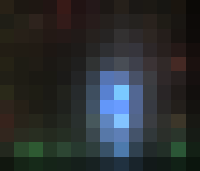
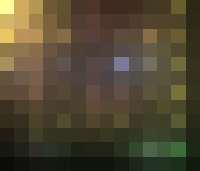
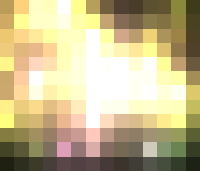
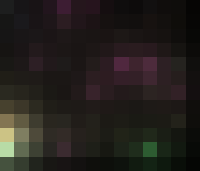
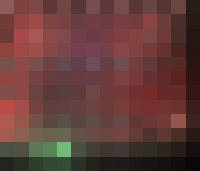
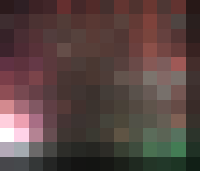
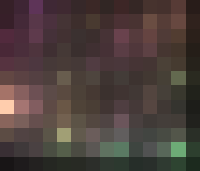
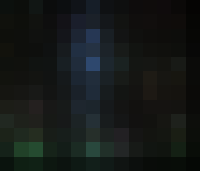
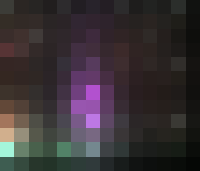
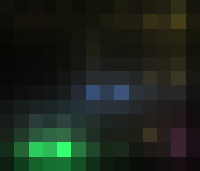

In [0]:
num_to_show = 10
start = random.randint(0, some_observations.shape[0]-num_to_show)

show(zoom_to(some_observations[start:start+num_to_show, :, :, 2:], 200))
show(zoom_to(some_observations[start:start+num_to_show, :, :, :3], 200))
show(zoom_to(attr_reduced[start:start+num_to_show], 200))